In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import statistics

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
"""
Function that loads and prepares the dataframe. 

Converts the data into time-series readable.
"""
def initialFormat (filepath, indicatorcode):
    #Reads the file and creates a dataframe from it
    df = pd.read_excel(filepath)
    
    #Choose what to forecast using indicator code
    df_icode = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df_icode = df_icode.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    #Swap axis so it is in the proper format
    df_formatted = df_icode.swapaxes("index", "columns")
    
    #Renaming column name to 'values' to make reference easier
    for col_names in df_formatted.columns:
        name = df_formatted.rename(columns={col_names : "Val"})
        return name
    
    return df_formatted

In [4]:
"""
Refactored from: 

https://cprosenjit.medium.com/10-time-series-forecasting-methods-we-should-know-291037d2e285

"""

def shift_dataframe(data):
    #The value in "shift(-x)" is the lookback period in this case 1.
    data["Target"] = data.Val.shift(-1)
    data.dropna(inplace=True)
    
    return data

In [5]:
def train_test_split(data, test_size):
    
    train = data[:-test_size]
    test = data[-test_size:]
    
    return train, test

In [6]:
def plot_train_test(train_set, test_set):
    ax = plt.plot(train_set, label='Train set')
    ax = plt.plot(test_set, label='Test set', color = 'orange')
    
    return ax

In [7]:
"""
This function is refactored from machine learning mastery to fit my data:

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
"""
def xgboost_model(train, X_test, data):
    train = np.asarray(train)
    #Split into X_train and y_train
    X_train, y_train = train[:,0:1], train[:, -1]
    
    tr, ts = train_test_split(data, len(data) - int(len(data)*0.8))
    
    X_test2, y_test2 = ts[:, :-1], ts[:,-1]
    
    eval_set = [(X_train, y_train), (X_test2, y_test2)]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=5, max_depth=3, learning_rate=0.15)
    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
    
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    #fig, ax = plt.subplots()
    #ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    #ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
    #ax.legend()
    #plt.ylabel('rmse loss')
    #plt.title('XGB rmse loss')
    #plt.show()
    
    y_pred = model.predict(np.asarray([X_test]))
    
    return y_train, X_train, y_pred[0]

In [8]:
"""
This function is refactored from machine learning mastery:

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

"""

def walk_forward_validation(data, test_size):
    predictions = list()
    
    train, test = train_test_split(data, test_size)
    
    history = [x for x in train]
    
    for i in range(len(test)):
        
        X_test, y_test = test[i, :-1], test[i, -1]
        
        y_train, X_train ,y_pred = xgboost_model(history, X_test, data)
        
        predictions.append(y_pred)
        
    return y_train, X_train, test[:, -1], predictions

In [9]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)

In [10]:
def mean_imputation(data):
    filled = data.fillna(data.mean())
    return filled

In [11]:
data = initialFormat('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'NY.GDP.DEFL.KD.ZG')

In [12]:
filled = mean_imputation(data)

In [13]:
shifted = shift_dataframe(filled)

In [14]:
finalData = shifted.values

In [15]:
train_index, test_index = train_test_split(shifted, len(data) - int(len(data) * 0.8))

In [16]:
finalData.dtype

dtype('float64')

In [17]:
y_train, X_train, actual, predicted = walk_forward_validation(finalData, len(data) - int(len(data) * 0.8))

RMSE:  6.818258393269825
MAPE:  109.94338517000809
MAE:  5.637288040926001
Scatter Index:  83.7394660681535
MDA:  0.16666666666666666
Mean of actual:  8.14222816720686


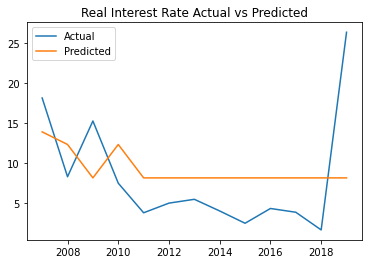

In [18]:
df_compare = pd.DataFrame({'Actual' : actual, 'Predicted' : predicted})
newindex = test_index.index.values.tolist()
df_compare.index = newindex
df_compare.plot(title='Real Interest Rate Actual vs Predicted')
performance_metrics(actual, predicted)

In [19]:
df_compare

,Actual,Predicted
2007,18.149751,13.898483
2008,8.274752,12.318882
2009,15.264294,8.129370
2010,7.465943,12.318882
2011,3.753879,8.129370
2012,4.965990,8.129370
2013,5.443175,8.129370
2014,3.980243,8.129370
2015,2.438924,8.129370
2016,4.292678,8.129370


In [20]:
"""
Starting here is the hyperparameter optimisation for univariate forecasting

This piece of code was reused from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

Fitted for my model

As the number of observations is not enough for a test and validation set 
kfold cross validation is used here.
"""

def tune_n_estimator(X, y):
    hyperparam = {'max_depth': [3,6,10],
                 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
                 'n_estimators': [5,10,50,100,1000]}
    
    model = XGBRegressor()
    
    gscv = GridSearchCV(estimator=model, param_grid=hyperparam,
                       scoring='neg_mean_squared_error',
                       verbose=1)
    
    gscv.fit(X, y)
    
    print("Best hyperparam: ", gscv.best_params_)

In [21]:
"""
Using X_train and Y_train due to how the target variable works for
time series forecast with XGBoost
"""
#tune_n_estimator(X_train, y_train)

'\nUsing X_train and Y_train due to how the target variable works for\ntime series forecast with XGBoost\n'

In [22]:
"""
Calc variance

used this guide for formula: https://www.scribbr.com/statistics/variance/
"""

dataMean = data.dropna().mean()
#print(dataMean)
n_minus_one = len(X_train) - 1
summed = 0
for vals in X_train:
        subtracted = vals - dataMean
        squared = subtracted ** 2
        summed = summed + squared

#print(summed)

varianced = summed / n_minus_one
print("Variance = ", varianced)

Variance =  Val    3080.425988
dtype: float64


Text(0.5, 1.0, 'Inflation Actual Data')

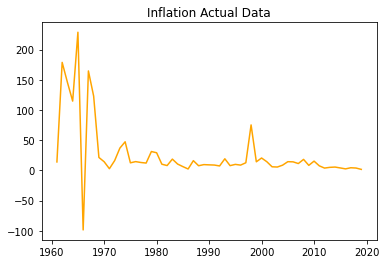

In [26]:
plt.plot(data, color='orange')
plt.title('Inflation Actual Data')

In [27]:
"""
107 Total Lines of code

x written by me
y copied from some guide
z taken and tweaked for my model
"""

'\n107 Total Lines of code\n'